In [2]:
%matplotlib notebook

In [1]:
import calour as ca
import numpy as np
import pandas as pd
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn.metrics import roc_curve, auc
from emperor import Emperor, nbinstall
from calour.training import plot_roc
import matplotlib.pyplot as plt
ca.set_log_level(40)

/Users/zech/miniconda3/envs/calour/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
exp = ca.read('../data/metabolome/features_TSNnorm.txt', 
              '../data/combined_sample_metadata_HFD.txt',
              normalize=100,
              feature_metadata_file='../data/metabolome/annotations_wStandards.txt')

exp = exp.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

In [5]:
exp

Experiment ("features_TSNnorm.txt") with 299 samples, 1889 features

# data preprocessing
Filter out OTUs low abundant in both of mouse models and the inital baseline samples (because they were fed with different diet).

In [6]:
# filtering features if the abundance is less than 'cutoff' in 'fraction' of samples in either 'field'
exp2 = exp.filter_prevalence(field='genotype', cutoff=0.1, fraction=0.1).filter_samples('age', [10, 10.5], 
                                                                                         negate=True)
exp2

Experiment ("features_TSNnorm.txt") with 263 samples, 377 features

In [7]:
# filter samples not labeled as Apoe or ldlr
exp2 = exp2.filter_samples('genotype', ['ApoE KO','LDLR KO'])

In [8]:
exp2.sample_metadata.genotype.value_counts()

ApoE KO    93
Name: genotype, dtype: int64

In [9]:
exp2_apoe = exp2.filter_samples('genotype', 'ApoE KO')
exp2_apoe.sample_metadata.exposure_type.value_counts()

Air    48
IHH    45
Name: exposure_type, dtype: int64

In [10]:
exp2_ldlr = exp2.filter_samples('genotype', 'LDLR KO')
exp2_ldlr.sample_metadata.exposure_type.value_counts()

Series([], Name: exposure_type, dtype: int64)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, auc

# Plot ROC curve using the abundance of each metabolites

<IPython.core.display.Javascript object>


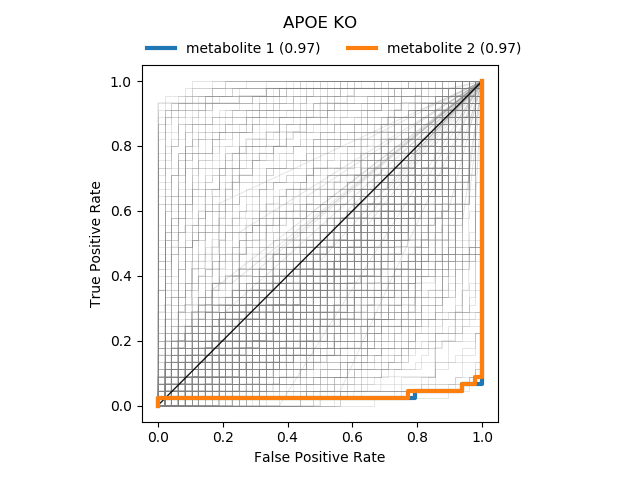

Text(0.5,1.08,'APOE KO')

In [102]:
from matplotlib import pyplot as plt
fig_apoe, ax_apoe = plt.subplots()
ax_apoe.set_aspect('equal')

fids_apoe = []
auc_apoe = []
for i in exp2_apoe.feature_metadata.index:
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_apoe.append(i)
        auc_apoe.append(a)
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=0.7, color='gray', alpha=0.2)

ax_apoe.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_apoe.set_xlim(-0.05, 1.05)
ax_apoe.set_ylim(-0.05, 1.05)
ax_apoe.set_xlabel('False Positive Rate')
ax_apoe.set_ylabel('True Positive Rate')
ax_apoe.set_title('APOE KO', y=1.08)

<IPython.core.display.Javascript object>


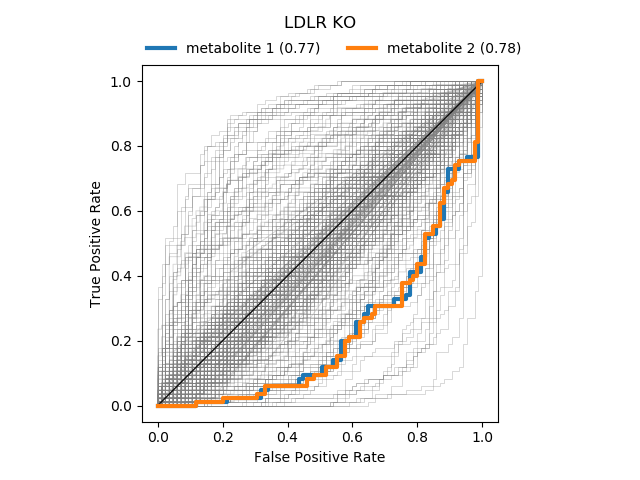

Text(0.5,1.08,'LDLR KO')

In [103]:
from matplotlib import pyplot as plt
fig_ldlr, ax_ldlr = plt.subplots()
ax_ldlr.set_aspect('equal')
fids_ldlr = []
auc_ldlr = []
for i in exp2_ldlr.feature_metadata.index:
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_ldlr.append(i)
        auc_ldlr.append(a)
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=0.7, color='gray', alpha=0.3)

ax_ldlr.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_ldlr.set_xlim(-0.05, 1.05)
ax_ldlr.set_ylim(-0.05, 1.05)
ax_ldlr.set_xlabel('False Positive Rate')
ax_ldlr.set_ylabel('True Positive Rate')
ax_ldlr.set_title('LDLR KO', y=1.08)

In [104]:
exp2.feature_metadata.head()

,row ID,row m/z,row retention time,LibraryID,standard_indentification_level_1,_feature_id
#featureID,,,,,,
110.02020789262785_7.81588739061257,1,110.020208,7.815887,NaN,NaN,110.02020789262785_7.81588739061257
496.3400991541585_5.156902118305356,2,496.340099,5.156902,1-Palmitoyl-sn-glycero-3-phosphocholine,NaN,496.3400991541585_5.156902118305356
357.2789208085304_4.965391768541157,3,357.278921,4.965392,Spectral Match to Chenodeoxycholic acid from N...,Deoxycholic acid,357.2789208085304_4.965391768541157
373.2738491153533_3.899919847020934,4,373.273849,3.899920,.beta.-Muricholic acid,a-Muricholic acid,373.2738491153533_3.899919847020934
373.27386451947183_3.9615752818035452,5,373.273865,3.961575,.beta.-Muricholic acid,b-Muricholic acid,373.27386451947183_3.9615752818035452


In [133]:
df1 = pd.DataFrame({'auc': auc_apoe, 'id': fids_apoe})
df2 = pd.DataFrame({'auc': auc_ldlr, 'id': fids_ldlr})

df = pd.merge(df1, df2, 'inner',  left_on='id', right_on='id', suffixes=('_ApoE', '_LDLR'))
df['sum_auc'] = df['auc_ApoE'] + df['auc_LDLR']
df['annot'] = exp2.feature_metadata.loc[df['id'], 'LibraryID'].values
df['annot2'] = exp2.feature_metadata.loc[df['id'], 'standard_indentification_level_1'].values
df.set_index('id', inplace=True)
df.sort_values('sum_auc', ascending=False, kind='mergesort', inplace=True)
df.sort_values('annot', ascending=False, kind='mergesort', inplace=True)


In [134]:
df

,auc_ApoE,auc_LDLR,sum_auc,annot,annot2
id,,,,,
283.2629498309951_5.430859365079369,0.971759,0.774118,1.745877,trans-Vaccenic acid,NaN
265.25244007223137_5.432108840227089,0.970833,0.776609,1.747442,cis-Vaccenic acid,NaN
255.2317783582418_5.1814566985645945,0.978241,0.751280,1.729521,cis-9-Hexadecenoic acid,NaN
516.300422276808_3.5346080964685593,0.962500,0.823806,1.786306,Spectral Match to Taurocholic acid from NIST14,NaN
516.3001954425159_3.6121693593314776,0.806944,0.831557,1.638502,Spectral Match to Taurocholic acid from NIST14,NaN
355.2633984884364_3.811552948402946,0.864815,0.826436,1.691251,Spectral Match to Cholic acid from NIST14,a-Muricholic acid
332.3307817246258_5.3103554720133594,0.750463,0.871003,1.621466,Spectral Match to Benzyltetradecyldimethylammo...,NaN
373.2738348512753_3.8372961569579247,0.796296,0.782007,1.578303,.beta.-Muricholic acid,a-Muricholic acid
423.2744890715284_4.29798541001065,0.919907,0.932318,1.852226,NaN,NaN


In [121]:
df.to_csv('../figures/table.s6.metabolites.tsv', sep='\t')

In [137]:
row1, row2 = df.iloc[1].copy(), df.iloc[5].copy()
df.iloc[1],df.iloc[5] = row2,row1

In [135]:
df['annot'][pd.notnull(df['annot2'])] = df['annot2']
df

/Users/zech/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,auc_ApoE,auc_LDLR,sum_auc,annot,annot2
id,,,,,
283.2629498309951_5.430859365079369,0.971759,0.774118,1.745877,trans-Vaccenic acid,NaN
265.25244007223137_5.432108840227089,0.970833,0.776609,1.747442,cis-Vaccenic acid,NaN
255.2317783582418_5.1814566985645945,0.978241,0.751280,1.729521,cis-9-Hexadecenoic acid,NaN
516.300422276808_3.5346080964685593,0.962500,0.823806,1.786306,Spectral Match to Taurocholic acid from NIST14,NaN
516.3001954425159_3.6121693593314776,0.806944,0.831557,1.638502,Spectral Match to Taurocholic acid from NIST14,NaN
355.2633984884364_3.811552948402946,0.864815,0.826436,1.691251,a-Muricholic acid,a-Muricholic acid
332.3307817246258_5.3103554720133594,0.750463,0.871003,1.621466,Spectral Match to Benzyltetradecyldimethylammo...,NaN
373.2738348512753_3.8372961569579247,0.796296,0.782007,1.578303,a-Muricholic acid,a-Muricholic acid
423.2744890715284_4.29798541001065,0.919907,0.932318,1.852226,NaN,NaN


In [143]:
features = []
for n, i in enumerate(df.index, 1):
    annot = df.loc[i, 'annot']
    if isinstance(annot, float) and np.isnan(annot):
        annot = '%f_%f' % (exp2.feature_metadata.loc[i, 'row m/z'], exp2.feature_metadata.loc[i, 'row retention time'])
    df_ = pd.DataFrame({'abundance': exp2[:, i],
                       'taxonomy': 'metabolite %d: ' % n + annot,
                       'feature': i,
                       'genotype': exp2.sample_metadata['genotype'],
                       'age': exp2.sample_metadata['age'],
                       'exposure_type': exp2.sample_metadata['exposure_type']})
    features.append(df_)

features = pd.concat(features, axis=0)

features.to_csv('common-imp-metabolites2.tsv', sep='\t')

In [145]:
for n, i in enumerate(df.index, 1):
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if n > 2:
        #ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color='black', alpha=0.5)
        pass
    else:
        ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=plt.cm.tab10.colors[n-1], label='metabolite %d (%.2f)' % (n, a))
ax_apoe.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_apoe.tight_layout()

In [146]:
for n, i in enumerate(df.index, 1):
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if n > 2:
        #ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color='black', alpha=0.5)
        pass
    else:
        ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=plt.cm.tab10.colors[n-1], label='metabolite %d (%.2f)' % (n, a))
ax_ldlr.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_ldlr.tight_layout()

In [147]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('roc-metabites2.pdf') as pdf:
    pdf.savefig(fig_apoe)
    pdf.savefig(fig_ldlr)

In [194]:
exp2_apoe.feature_metadata.head()

,row ID,row m/z,row retention time,LibraryID,standard_indentification_level_1,_feature_id
#featureID,,,,,,
110.02020789262785_7.81588739061257,1,110.020208,7.815887,NaN,NaN,110.02020789262785_7.81588739061257
496.3400991541585_5.156902118305356,2,496.340099,5.156902,1-Palmitoyl-sn-glycero-3-phosphocholine,NaN,496.3400991541585_5.156902118305356
357.2789208085304_4.965391768541157,3,357.278921,4.965392,Spectral Match to Chenodeoxycholic acid from N...,Deoxycholic acid,357.2789208085304_4.965391768541157
373.2738491153533_3.899919847020934,4,373.273849,3.899920,.beta.-Muricholic acid,a-Muricholic acid,373.2738491153533_3.899919847020934
373.27386451947183_3.9615752818035452,5,373.273865,3.961575,.beta.-Muricholic acid,b-Muricholic acid,373.27386451947183_3.9615752818035452


In [148]:
!open roc-metabites2.pdf

R code plot metabolite abundance trend:

In [149]:
!open trend-metabolites2.pdf

In [271]:
!open trend-metabolites-colors.pdf